# Import

In [ ]:
import os
import cv2
import time
import random
import numpy as np
from glob import glob
from tqdm import tqdm
from operator import add

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

# Dataset Class

In [ ]:
class DriveDataset(Dataset):
  def __init__(self,images_path,masks_path):
    self.images_path = images_path
    self.masks_path = masks_path
    self.n_samples = len(images_path)

  def __getitem__(self,index):
    #reading images
    image = cv2.imread(self.images_path[index],cv2.IMREAD_COLOR)
    image = image/255
    image = np.transpose(image,(2,0,1))
    image = image.astype(np.float32)
    image = torch.from_numpy(image)

    #reading masks
    mask = cv2.imread(self.masks_path[index],cv2.IMREAD_GRAYSCALE)
    mask = mask/255
    mask = np.expand_dims(mask,axis=0)
    mask = mask.astype(np.float32)
    mask = torch.from_numpy(mask)

    return image,mask

  def __len__(self):
    return self.n_samples



# Convolution Layer Class

In [ ]:
class conv_block(nn.Module):
  def __init__(self,in_c,out_c):
    super().__init__()

    self.conv1 = nn.Conv2d(in_c,out_c,kernel_size=3,padding=1)
    self.relu = nn.ReLU()


  def forward(self,inputs):
    x = self.conv1(inputs)
    x = self.relu(x)
    return x

# The Encoder Block

In [ ]:
class encoder_block(nn.Module):
  def __init__(self,in_c,out_c):
    super().__init__()
    self.conv = conv_block(in_c,out_c)
    self.pool = nn.MaxPool2d((2,2))

  def forward(self,inputs):
    x = self.conv(inputs)
    p = self.pool(x)

    return x,p

# The Decoder Block

In [ ]:
class decoder_block(nn.Module):
  def __init__(self,in_c,out_c):
    super().__init__()
    self.up = nn.ConvTranspose2d(in_c,out_c,kernel_size=2,stride=2,padding=0)
    self.conv = conv_block(out_c+out_c,out_c)

  def forward(self,inputs,skip):
    x = self.up(inputs)
    x = torch.cat([x,skip],axis=1)
    x = self.conv(x)
    return x


# The U-Net Architecture

In [ ]:
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)

        # Bottleneck
        self.b = conv_block(128,256)

        # Decoder
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        # Classifier
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        # Encoder
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)


        # Bottleneck
        b = self.b(p2)

        # Decoder
        d3 = self.d3(b, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs


# Dice Coefficient

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

# Dice Binary Cross Entropy Coefficient

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

#Few Helper Function

In [ ]:
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Function to Train the Data

In [ ]:
def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

# Function to Evaluate the model

In [ ]:
def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss / len(loader)
    return epoch_loss

# Get  Data Paths

In [ ]:
# Seeding
seeding(42)

# Create files directory to store checkpoint file
create_dir("files")
path = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/Retina"
#  Get data paths
train_x = sorted(glob(path+"/Data/train/image/*"))
train_y = sorted(glob(path+"/Data/train/mask/*"))

valid_x = sorted(glob(path+"/Data/test/image/*"))
valid_y = sorted(glob(path+"/Data/test/mask/*"))

data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
print(data_str)

Dataset Size:
Train: 80 - Valid: 20



# Set Hyper Parameters

In [ ]:
H = 512
W = 512
size = (H, W)
batch_size = 2
lr = 1e-4
checkpoint_path = path + "/retina_checkpoint.pth"

# Load Dataset

In [ ]:
train_dataset = DriveDataset(train_x, train_y)
valid_dataset = DriveDataset(valid_x, valid_y)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

# Instantiate U-net

In [ ]:
# Set cuda device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Build model
model = build_unet()
model = model.to(device)

# Set Optimizer and Loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Load the trained model if exists

In [ ]:
try:
  # Load the model's state dictionary
  model.load_state_dict(torch.load(checkpoint_path))
except Exception as e:
    print(e)

<ipython-input-23-39c0d8b3146d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


# Training The Model

In [ ]:
best_valid_loss = float("inf")
num_epochs = 1

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    valid_loss = evaluate(model, valid_loader, loss_fn, device)

    # Saving the model
    if valid_loss < best_valid_loss:
        print(f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}")

        best_valid_loss = valid_loss
        torch.save(model.state_dict(), checkpoint_path)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
    data_str += f'\tTrain Loss: {train_loss:.3f}\n'
    data_str += f'\tVal. Loss: {valid_loss:.3f}\n'
    print(data_str)

Valid loss improved from inf to 0.7182. Saving checkpoint: /content/drive/MyDrive/Colab Notebooks/Computer Vision/Retina/retina_checkpoint.pth
Epoch: 01 | Epoch Time: 16m 20s
	Train Loss: 0.842
	Val. Loss: 0.718



# Helper Functions for Testing

## Calculate Metrics

In [ ]:
def calculate_metrics(y_true, y_pred):
    # Ground truth
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    # Prediction
    y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc]

## Function to parse the mask

In [ ]:
def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

## Get Test Data

In [ ]:
#  Seeding
seeding(42)

# Folders
create_dir("results")

# Load dataset
test_x = sorted(glob(path+"/Data/test/image/*"))
test_y = sorted(glob(path+"/Data/test/mask/*"))


## Load Checkpoint

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = build_unet()
model = model.to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

<ipython-input-26-0e9dee835c13>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


build_unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (b): conv_block(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
  )
  (d3): decoder_block(
    (up): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (conv): conv_block(
      (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
  )
  (d4): decoder_block(
    (up): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (conv): conv_block(
    

# Test

In [ ]:
metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
time_taken = []

for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
    # Extract the name
    name = x.split("/")[-1].split(".")[0]

    # Reading image
    image = cv2.imread(x, cv2.IMREAD_COLOR) ## (512, 512, 3)
    x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
    x = x / 255.0
    x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
    x = x.astype(np.float32)
    x = torch.from_numpy(x)
    x = x.to(device)

    # Reading mask
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
    y = np.expand_dims(mask, axis=0)            ## (1, 512, 512)
    y = y / 255.0
    y = np.expand_dims(y, axis=0)               ## (1, 1, 512, 512)
    y = y.astype(np.float32)
    y = torch.from_numpy(y)
    y = y.to(device)

    with torch.no_grad():
        # Prediction and Calculating FPS
        start_time = time.time()
        pred_y = model(x)
        pred_y = torch.sigmoid(pred_y)
        total_time = time.time() - start_time
        time_taken.append(total_time)

        score = calculate_metrics(y, pred_y)
        metrics_score = list(map(add, metrics_score, score))
        pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
        pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
        pred_y = pred_y > 0.5
        pred_y = np.array(pred_y, dtype=np.uint8)

    # Saving masks
    ori_mask = mask_parse(mask)
    pred_y = mask_parse(pred_y)
    line = np.ones((size[1], 10, 3)) * 128

    # Concatenate images
    cat_images = np.concatenate(
        [image, line, ori_mask, line, pred_y * 255], axis=1
    )

    # Add labels to the images
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_color = (255, 255, 255)
    thickness = 2
    line_type = cv2.LINE_AA

    # Add text to the original image
    cv2.putText(cat_images, "Original", (10, 50), font, font_scale, font_color, thickness, line_type)

    # Add text to the ground truth mask
    cv2.putText(cat_images, "Ground Truth", (image.shape[1] + 20, 50), font, font_scale, font_color, thickness, line_type)

    # Add text to the predicted mask
    cv2.putText(cat_images, "Prediction", (2 * image.shape[1] + 40, 50), font, font_scale, font_color, thickness, line_type)

    # Save the resulting image
    cv2.imwrite(f"results/{name}.png", cat_images)


100%|██████████| 20/20 [01:29<00:00,  4.50s/it]


# Test Evaluation

In [ ]:
jaccard = metrics_score[0] / len(test_x)
f1 = metrics_score[1] / len(test_x)
recall = metrics_score[2] / len(test_x)
precision = metrics_score[3] / len(test_x)
acc = metrics_score[4] / len(test_x)
print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f}")

fps = 1 / np.mean(time_taken)
print("FPS: ", fps)

Jaccard: 0.4149 - F1: 0.5817 - Recall: 0.5497 - Precision: 0.6799 - Acc: 0.9296
FPS:  0.2381352765769578


# Show the Result

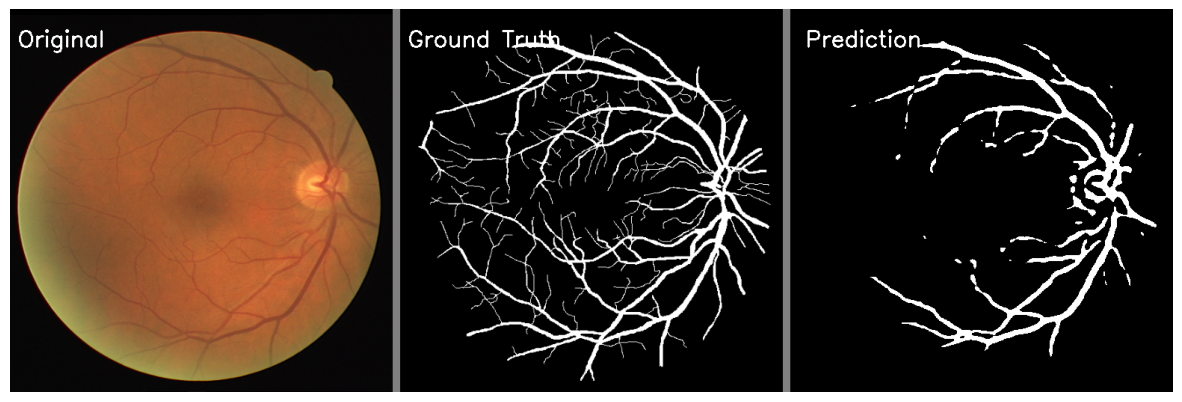

In [ ]:
import matplotlib.pyplot as plt

img = plt.imread(path+'/results/5.png')
plt.figure(figsize=(15, 8))
plt.imshow(img)
plt.axis('off')

plt.show()

# Generate Diagram of Model

In [ ]:
!pip install torchview

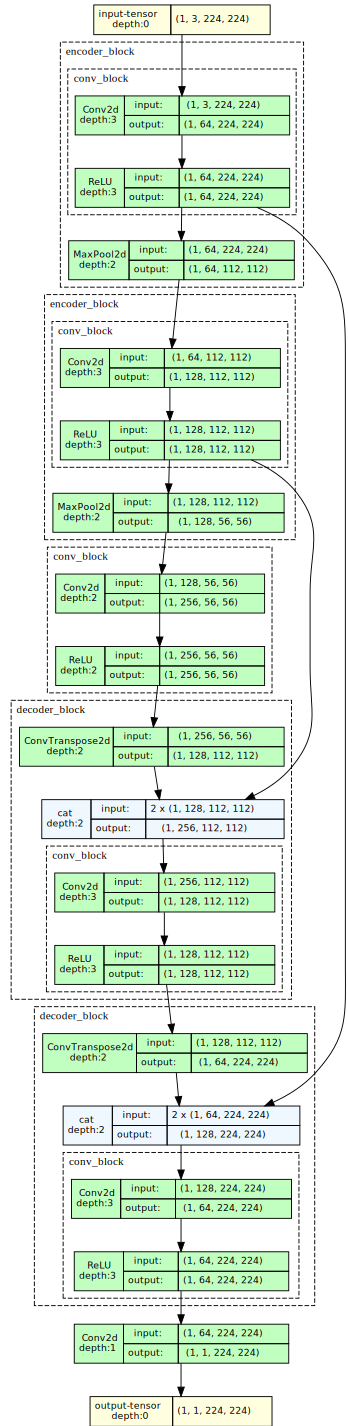

In [ ]:
from torchview import draw_graph
# Instantiate the model
unet = build_unet()

# Define an input tensor
input_tensor = torch.randn(1, 3, 224, 224)  # Example input tensor with batch size 1 and 224x224 image

# Draw the graph
model_graph = draw_graph(unet, input_data=input_tensor, expand_nested=True)

# Render and save the graph using graphviz
model_graph.visual_graph.render(filename="unet_model_graph", format="png", cleanup=True)

model_graph.visual_graph

In [ ]:
!pip3 install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 28.2 MB/s eta 0:00:00


In [ ]:
# Export model to ONNX
dummy_input = torch.randn(1, 3, 224, 224)
torch.onnx.export(unet, dummy_input, path+"unet_.onnx", opset_version=11)

# Open the "unet_.onnx" file in Netron